<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/SpaceVector_SPWM_Averaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Space Vector Averaging</h1></b>

Dr. Bingsen Wang

7/16/2024
</center>

#Space Vector

The space vector is complex variable defined as
$$\underline f = {2\over3}\left(f_a + f_be^{j\frac{2\pi}{3}} + f_ce^{j\frac{4\pi}{3}}\right)\tag{1}$$
where $f_a,f_b,f_c$ are the three-phase variables. In electrical systems, the variable $f$ can be voltage $v$, current $i$, or flux linkage $\lambda$. In power electronics systems, the variable $f$ can be the modulation function or switching function.

#Python Code
The Python code illustrates the space vector averaged over a switching period.

0
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0


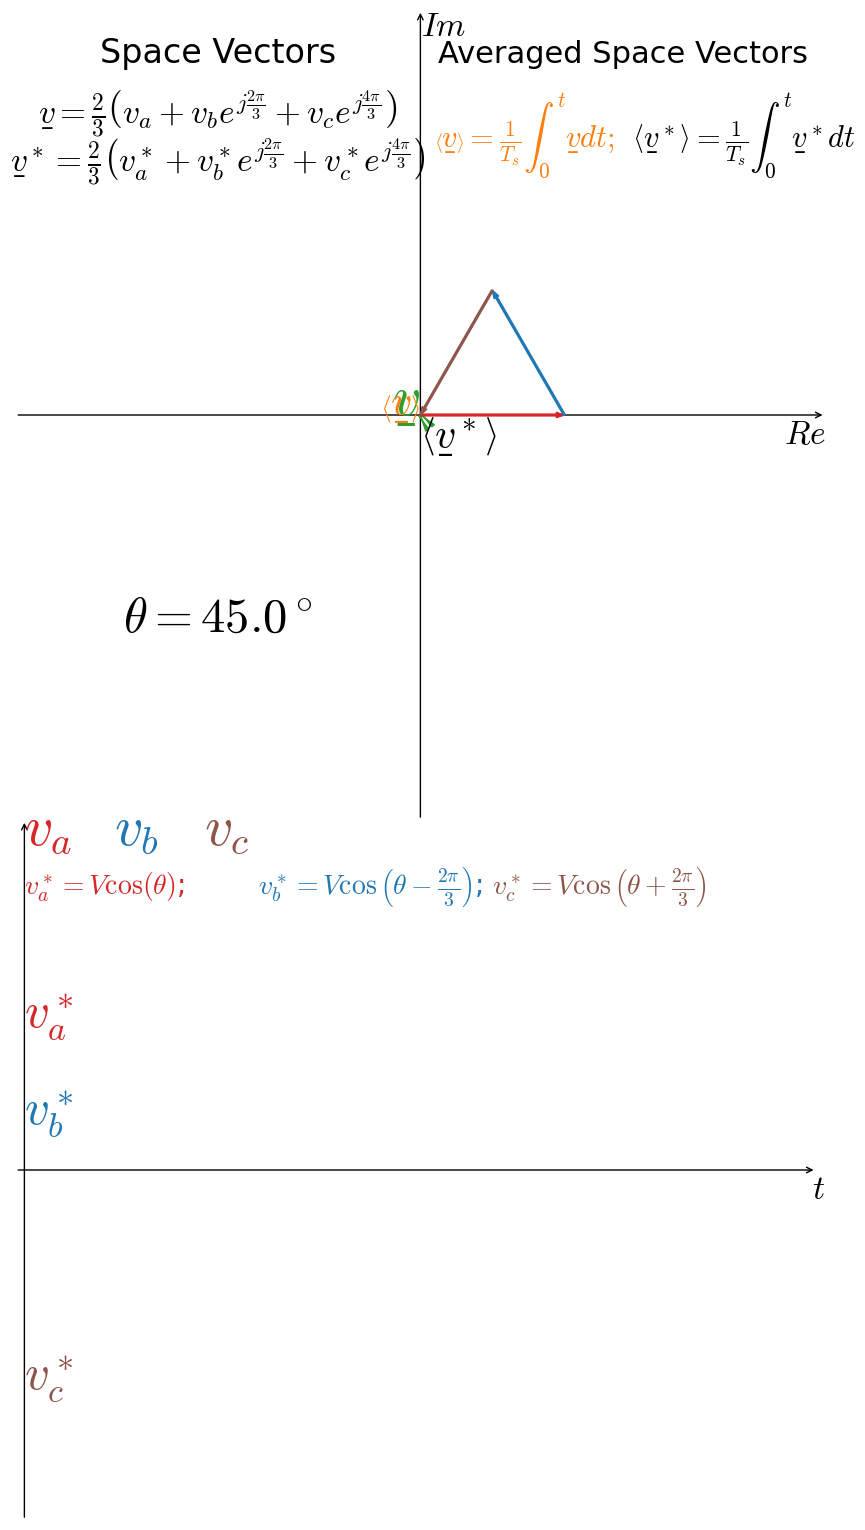

In [32]:
import matplotlib
from os import linesep
from scipy import integrate
import numpy as np
from numpy import linspace,cos,arccos,pi,exp
import matplotlib.pyplot as plt
import matplotlib.patches as mp
from matplotlib import animation,rc,rcParams
rc('animation', html='jshtml')
plt.rcParams.update({"font.family":"sans-serif", "mathtext.fontset":"cm"})

#carrier
def carrier(t,fs):
  return 2/pi*arccos(cos(2*pi*fs*t))-1

#modulation functions
def mf_abc(t,f,MI,theta):
  mf=[]
  for i in range(3):
    mf.append(MI*cos(2*pi*f*t+theta-i*2*pi/3))
  return np.array(mf)

#PWM voltage waveforms
def vac_abc(t,V,f,MI,theta,fs):
  vac=[]
  for i in range(3):
    vac.append(V*(2*np.heaviside(mf_abc(t,f,MI,theta)[i]-carrier(t,fs),0)-1))
  return np.array(vac)

#integration of space vector of pwm
def sv_modulation_dt(t1,t2,f,MI,theta):
  sv=0
  for i in range(3):
    v_dt = integrate.fixed_quad(lambda x: mf_abc(x,f,MI,theta)[i],t1,t2)
    sv += 2/3*v_dt[0]*exp(1j*i*2*pi/3)
  return sv

#integration of space vector of pwm
def sv_pwm_dt(t1,t2,V,f,MI,theta,fs):
  sv=0
  for i in range(3):
    v_dt = integrate.fixed_quad(lambda x: vac_abc(x,V,f,MI,theta,fs)[i],t1,t2)
    sv += 2/3*v_dt[0]*exp(1j*i*2*pi/3)
  return sv

#parameters
Nfps = 450 #number of frames per scene
Ns = 2 #number of scenes
f = 1/(2*pi) # fundamental frequency in Hz
T = 1/f #fundamental period
fs = 240*f #switching frequency
Ts = 1/fs #switching period

t=linspace(0,Ts,Nfps)
wt = 2*pi*f*t
V = 2.4 #voltage
theta1=pi/4
theta2 = 5*pi/6*1.05
MI=0.9 #modulation index
carr= V*carrier(t,fs) #carrier ranges [-1,1]
vabc_modulation1=V*mf_abc(t,f*0,MI,theta1)
vabc_modulation2=V*mf_abc(t,f*0,MI,theta2)
vabc_pwm1 = vac_abc(t,V,f,MI,theta1,fs)
vabc_pwm2 = vac_abc(t,V,f,MI,theta2,fs)
v_sv1 = 2/3*(vabc_pwm1[0]+vabc_pwm1[1]*exp(1j*2*pi/3)+vabc_pwm1[2]*exp(1j*4*pi/3))
v_sv2 = 2/3*(vabc_pwm2[0]+vabc_pwm2[1]*exp(1j*2*pi/3)+vabc_pwm2[2]*exp(1j*4*pi/3))
v_star_sv1 = 2/3*(vabc_modulation1[0]+vabc_modulation1[1]*exp(1j*2*pi/3)+vabc_modulation1[2]*exp(1j*4*pi/3))
v_star_sv2 = 2/3*(vabc_modulation2[0]+vabc_modulation2[1]*exp(1j*2*pi/3)+vabc_modulation2[2]*exp(1j*4*pi/3))
lambda1_sv=[0] #averaged space vector of pwm
lambda2_sv=[0] #averaged space vector of pwm
lambda1_star_sv=[0] #averaged space vector of reference voltages
lambda2_star_sv=[0] #averaged space vector of reference voltages
for i in range(1,Nfps):
  lambda1_sv.append(sv_pwm_dt(t[i-1],t[i],V,f,MI,theta1,fs) + lambda1_sv[-1])
  lambda2_sv.append(sv_pwm_dt(t[i-1],t[i],V,f,MI,theta2,fs) + lambda2_sv[-1])
  lambda1_star_sv.append(sv_modulation_dt(t[i-1],t[i],f*0,MI,theta1) + lambda1_star_sv[-1])
  lambda2_star_sv.append(sv_modulation_dt(t[i-1],t[i],f*0,MI,theta2) + lambda2_star_sv[-1])
lambda1_sv=np.array(lambda1_sv)/Ts
lambda2_sv=np.array(lambda2_sv)/Ts
lambda1_star_sv=V*np.array(lambda1_star_sv)/Ts
lambda2_star_sv=V*np.array(lambda2_star_sv)/Ts

xymax = 4.5
clst=['tab:red','tab:blue','tab:brown','tab:green','tab:olive','tab:orange','k','w'] #colors light bg
# clst=['lightskyblue','violet','yellow','lightgreen','tab:olive','tab:orange','w',(.1,.1,.1)] #colors dark bg
fig = plt.figure(figsize=(9,16),facecolor=clst[-1])
fig.tight_layout()
ax=fig.add_axes((0.05,7/16,.9,.9*9/16),xlim=[-xymax,xymax], ylim=[-xymax,xymax],fc='none') #no fc
ax0=fig.add_axes((0.05,7/16,.9,.9*9/16),xlim=[-xymax,xymax], ylim=[-xymax,xymax],fc='none') #no fc for animated parts
ax1=fig.add_axes((0.05,0,.9,7/16),xlim=[-.1,2*xymax-.1], ylim=[-xymax*7/9,xymax*7/9],fc='none') #no fc
ax.axis('off') #turn off axis frames
ax1.axis('off') #turn off axis frames
ax.annotate("", (xymax, 0), (-xymax, 0),arrowprops={'arrowstyle':"->",'color':clst[-2]}) #x-axis for space vector
ax.annotate("", (0,xymax), (0,-xymax),arrowprops={'arrowstyle':"->",'color':clst[-2]}) #y-axis for space vector
ax1.annotate("", (2*xymax-.2, 0), (-.1, 0),arrowprops={'arrowstyle':"->",'color':clst[-2]}) #x-axis for voltages
ax1.annotate("", (0,xymax*7/9), (0,-xymax*7/9),arrowprops={'arrowstyle':"->",'color':clst[-2]}) #y-axis for voltages
ax.text(xymax,-.03,'$Re$',size=24,va='top',ha='right',color=clst[-2]) #x-axis label
ax.text(0.01,xymax,'$Im$',size=24,va='top',color=clst[-2]) #y label
ax.text(-xymax*.5,xymax*.87,'Space Vectors',size=24,ha='center',color=clst[-2]) #space vector label
ax.text(-xymax*.5,xymax*.72,r'$v\underbar = \frac{2}{3}\left(v_a + v_b e^{j\frac{2\pi}{3}}+ v_c e^{j\frac{4\pi}{3}}\right)$',
        size=24,ha='center',color=clst[-2])
ax.text(-xymax*.5,xymax*.6,r'${v\underbar}^* = \frac{2}{3}\left(v_a^* + v_b^* e^{j\frac{2\pi}{3}}+ v_c^* e^{j\frac{4\pi}{3}}\right)$',
        size=24,ha='center',color=clst[-2])
ax.text(xymax*.5,xymax*.87,'Averaged Space Vectors',size=22,ha='center',color=clst[-2]) #space vector label
ax.text(xymax*.5,xymax*.66,r'$\left<v\underbar\right> = \frac{1}{T_s}\int_0^t v\underbar dt;$ ',
        size=22,ha='right',color=clst[5])
ax.text(xymax*.5,xymax*.66,r' $\left<v\underbar^*\right> = \frac{1}{T_s}\int_0^t v\underbar^* dt$',
        size=22,ha='left',color=clst[-2])


lines = [] #array containing all the line plots
lines.append(ax.plot([], [], '-', lw=5, color=clst[4],alpha=.9)[0]) #flux linkage trajectory
for i in range(3):
  lines.append(ax1.plot([], [], '-', lw=3-i, color=clst[i],alpha=1)[0]) #v_a,v_b,v_c PWM
  lines.append(ax1.plot([], [], '--', lw=3-i, color=clst[i],alpha=.8)[0]) #v_a,v_b,v_c modulation
lines.append(ax1.plot([], [], '-', lw=1, color=clst[-2], alpha=.7)[0]) #carrier
labels_vabc = [r'$v_a$',r'$v_b$',r'$v_c$']
labels_vabc_star = [r'$v_a^*$',r'$v_b^*$',r'$v_c^*$']
labels_vabc_star1 = [r'$v_a^* = V\cos(\theta)$;',
                     r'$v_b^*=V\cos\left(\theta-\frac{2\pi}{3}\right)$;',
                     r'$v_c^*=V\cos\left(\theta+\frac{2\pi}{3}\right)$']
text_vabc_star =[]
for i in range(3):
  ax1.text(i,xymax*6.5/9,labels_vabc[i],size=40,color=clst[i]) #vabc
  ax1.text(i*2.6,xymax*5.5/9,labels_vabc_star1[i],size=20,color=clst[i]) #vabc
  text_vabc_star.append(ax1.text(0,vabc_modulation1[i,0],labels_vabc_star[i],
                                 size=35,va='center',color=clst[i])) #vabc_star

ax1.text(2*xymax-.1,-.03,r'$t$',size=24,va='top',ha='right', color=clst[-2]) #x-axis label
text_theta = ax.text(-.5*xymax,-.5*xymax,'',size=35,va='center',ha='center', color=clst[-2])

def drawVectors(ax,xymax,lambda_sv,lambda_star_sv,v_pwm_sv,vabc,clst):
  theta_v = np.angle(v_pwm_sv)
  if theta_v<0:
    theta_v = 2*pi+theta_v
  theta_l = np.angle(lambda_sv)
  if theta_l<0:
    theta_l = 2*pi+theta_l
  ax.clear()
  ax.set_xlim([-xymax,xymax])
  ax.set_ylim([-xymax,xymax])
  ax.axis('off')
  arr = mp.FancyArrow(0,0,v_pwm_sv.real, v_pwm_sv.imag, width=.04,length_includes_head=True,
                   color=clst[3]) #space vector v_sv
  ax.add_patch(arr)
  arr = mp.FancyArrow(0,0,lambda_sv.real, lambda_sv.imag, width=.06,length_includes_head=True,
                   color=clst[5]) #space vector lambda_sv
  ax.add_patch(arr)
  arr = mp.FancyArrow(0,0,lambda_star_sv.real, lambda_star_sv.imag, width=.04,length_includes_head=True,
                   color=clst[-2]) #space vector lambda_star_sv
  ax.add_patch(arr)
  for i in range(3):
    v=0
    for ii in range(i):
      v+=vabc[ii]*exp(1j*2*pi/3**ii)*2/3
    arr = mp.FancyArrow(v.real,v.imag,(vabc[i]*exp(1j*i*2*pi/3)).real*2/3,
     (vabc[i]*exp(1j*i*2*pi/3)).imag*2/3, width=.02,length_includes_head=True,
     color=clst[i]) #v_a,v_b,v_c
    ax.add_patch(arr)
  t1 = ax.text(v_pwm_sv.real,v_pwm_sv.imag,r'$v\underbar$', size = 40, color=clst[3])
  if theta_v>pi/2 and theta_v<3*pi/2:
    t1.set_ha('right')
  if theta_v>pi:
    t1.set_va('top')
  t2 = ax.text(lambda_sv.real,lambda_sv.imag,r'$\left<v\underbar\right>$',
               size = 30, color=clst[5])
  t3 = ax.text(lambda_star_sv.real,lambda_star_sv.imag,r'$\left<v\underbar^*\right>$',
               size = 30, color=clst[-2])
  if theta_l<pi/2:
    t2.set_ha('right')
    t3.set_va('top')
  else:
    t2.set_va('bottom')
    t3.set_ha('right')
    # t3.set_va('top')
  # if theta_l>pi:
  #   t2.set_va('top')
  return

# animation function. This is called sequentially
def animate(i):
  if i%50==0: #for monitoring the progress
    print(i)
  # i=599
  if int(i/Nfps)==0:
    lambda_sv=lambda1_sv
    lambda_star_sv=lambda1_star_sv
    vabc_pwm=vabc_pwm1
    vabc_modulation=vabc_modulation1
    v_sv=v_sv1
    text_theta.set_text(r'$\theta = {:.1f}^\circ$'.format(theta1/pi*180))
  else:
    i=i%Nfps
    lambda_sv=lambda2_sv
    lambda_star_sv=lambda2_star_sv
    vabc_pwm=vabc_pwm2
    vabc_modulation=vabc_modulation2
    v_sv=v_sv2
    text_theta.set_text(r'$\theta = {:.1f}^\circ$'.format(theta2/pi*180))
  lines[0].set_data(lambda_sv[:i+1].real,lambda_sv[:i+1].imag) #flux linkage trajectory
  for k in range(3):
    lines[2*k+1].set_data(t[:i+1]/max(t)*xymax*1.7,vabc_pwm[k][:i+1]) #v_a,v_b,v_c PWM
    lines[2*k+2].set_data(t[:i+1]/max(t)*xymax*1.7,vabc_modulation[k][:i+1]) #v_abc modulation
    text_vabc_star[k].set_position((t[i]/max(t)*xymax*1.7,vabc_modulation[k,0])) #vabc_star
  lines[7].set_data(t[:i+1]/max(t)*xymax*1.7,carr[:i+1]) #carrier
  drawVectors(ax0,xymax,lambda_sv[i],lambda_star_sv[i],v_sv[i],vabc_pwm[:,i],clst)
  return

anim = animation.FuncAnimation(fig, animate, frames=Nfps*Ns, interval=50)
fn = r"SpaceVector_Averaging.mp4"
writervideo = animation.FFMpegWriter(fps=20)
anim.save(fn, writer=writervideo,dpi = 200)